In [1]:
%load_ext tensorboard
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import datetime
import os
import scipy.io
import tarfile
from PIL import Image
from tqdm.notebook import tqdm_notebook
import sklearn
import tensorflow as tf
from sklearn.model_selection import train_test_split
print(tf.__version__)

2.0.0


In [2]:
tf.test.is_gpu_available(
    cuda_only=False,
    min_cuda_compute_capability=None
)

True

In [3]:
!wget http://www.robots.ox.ac.uk/~vgg/data/flowers/102/102flowers.tgz

--2019-12-16 11:06:37--  http://www.robots.ox.ac.uk/~vgg/data/flowers/102/102flowers.tgz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 344862509 (329M) [application/x-gzip]
Saving to: ‘102flowers.tgz.1’

102flowers.tgz.1    100%[===================>] 328.89M  83.7MB/s    in 4.0s    

2019-12-16 11:06:41 (81.4 MB/s) - ‘102flowers.tgz.1’ saved [344862509/344862509]



In [4]:
!wget http://www.robots.ox.ac.uk/~vgg/data/flowers/102/imagelabels.mat

--2019-12-16 11:06:41--  http://www.robots.ox.ac.uk/~vgg/data/flowers/102/imagelabels.mat
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 502
Saving to: ‘imagelabels.mat.1’

imagelabels.mat.1   100%[===================>]     502  --.-KB/s    in 0s      

2019-12-16 11:06:41 (57.8 MB/s) - ‘imagelabels.mat.1’ saved [502/502]



In [5]:
labels = scipy.io.loadmat('imagelabels.mat')
labels = np.array(labels['labels'][0])

In [6]:
imageFile  = tarfile.open(name='102flowers.tgz', mode='r:gz')

savepath = '/tmp/102flowers/'

imageFile.extractall(savepath)

In [7]:
train_path = '/tmp/train/'
test_path = '/tmp/test/'
if not os.path.isdir(train_path):
  os.mkdir(train_path)
if not os.path.isdir(test_path):
  os.mkdir(test_path)

In [8]:
count_M20 = 0
for i in range(101):
    rand = np.random.randint(0, 100, dtype= np.int64)
    if rand > 20:
        count_M20 += 1
print(count_M20, '%')

81 %


In [9]:
path = savepath + 'jpg/'
np.random.seed(42)
for f in tqdm_notebook(os.listdir(path), total= len(os.listdir(path))):
  image = Image.open(os.path.join(path, f))
  image_id = int(f.replace('image_', "").replace('.jpg',""))
  rand = np.random.randint(0,100,dtype= np.int64)
  if rand > 20:
    if not os.path.isdir(train_path + str(labels[image_id-1])):
        os.mkdir(train_path + str(labels[image_id-1]))
    image.save(train_path + str(labels[image_id-1]) + '/' + f )
  else:
    if not os.path.isdir(test_path + str(labels[image_id-1])):
        os.mkdir(test_path + str(labels[image_id-1]))
    image.save(test_path + str(labels[image_id-1]) + '/' + f )

In [28]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

class FixedImageDataGenerator(ImageDataGenerator):
    def standardize(self, x):
        if self.featurewise_center:
            x = ((x/255.) - 0.5) * 2.
        return x
    
data_gen_args = dict(featurewise_center=True,
                     featurewise_std_normalization=True,
                     rotation_range=90,
                     width_shift_range=0.1,
                     height_shift_range=0.1,
                     zoom_range=0.2,
                     rescale = 1/255.,
                     validation_split=0.22)

#train_datagen = ImageDataGenerator(rescale = 1/255., validation_split=0.2)

train_datagen = FixedImageDataGenerator(**data_gen_args)

train_generator = train_datagen.flow_from_directory(train_path, subset='training', target_size = (500,500), batch_size = 16, class_mode = 'categorical', seed=42, shuffle=True)

valid_generator = train_datagen.flow_from_directory(train_path, subset='validation', target_size = (500,500), batch_size = 16, class_mode = 'categorical', seed=42, shuffle=True)

#train_generator = train_datagen.flow(imgs, y_one_hot, batch_size=128, subset='training', seed=42)

test_datagen = FixedImageDataGenerator(rescale= 1/255.)

test_generator = test_datagen.flow_from_directory(test_path, target_size= (500,500), batch_size = 16, class_mode = 'categorical', seed = 42, shuffle=True)

test_genarator2 = train_datagen.flow_from_directory(test_path, target_size= (500,500), batch_size = 16, class_mode = 'categorical', seed = 42, shuffle=True)

Found 5071 images belonging to 102 classes.
Found 1361 images belonging to 102 classes.
Found 1757 images belonging to 102 classes.
Found 1757 images belonging to 102 classes.


In [11]:
IMG_WIDTH, IMG_HEIGHT, CHANNELS = (500,500,3)
eps = 1.1e-5
concat_axis = 3

In [12]:
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

from tensorflow.keras.layers import Layer, InputSpec
try:
    from tensorflow.keras import initializations
except ImportError:
    from tensorflow.keras import initializers as initializations

class Scale(Layer):
    '''Custom Layer for DenseNet used for BatchNormalization.
    
    Learns a set of weights and biases used for scaling the input data.
    the output consists simply in an element-wise multiplication of the input
    and a sum of a set of constants:
        out = in * gamma + beta,
    where 'gamma' and 'beta' are the weights and biases learnt.
    # Arguments
        axis: integer, axis along which to normalize in mode 0. For instance,
            if your input tensor has shape (samples, channels, rows, cols),
            set axis to 1 to normalize per feature map (channels axis).
        momentum: momentum in the computation of the
            exponential average of the mean and standard deviation
            of the data, for feature-wise normalization.
        weights: Initialization weights.
            List of 2 Numpy arrays, with shapes:
            `[(input_shape,), (input_shape,)]`
        beta_init: name of initialization function for shift parameter
            (see [initializations](../initializations.md)), or alternatively,
            Theano/TensorFlow function to use for weights initialization.
            This parameter is only relevant if you don't pass a `weights` argument.
        gamma_init: name of initialization function for scale parameter (see
            [initializations](../initializations.md)), or alternatively,
            Theano/TensorFlow function to use for weights initialization.
            This parameter is only relevant if you don't pass a `weights` argument.
    '''
    def __init__(self, weights=None, axis=-1, momentum = 0.9, beta_init='zero', gamma_init='one', **kwargs):
        self.momentum = momentum
        self.axis = axis
        self.beta_init = initializations.get(beta_init)
        self.gamma_init = initializations.get(gamma_init)
        self.initial_weights = weights
        super(Scale, self).__init__(**kwargs)

    def build(self, input_shape):
        self.input_spec = [InputSpec(shape=input_shape)]
        shape = (int(input_shape[self.axis]),)

        self.gamma = tf.Variable(self.gamma_init(shape), name='{}_gamma'.format(self.name))
        self.beta = tf.Variable(self.beta_init(shape), name='{}_beta'.format(self.name))
        #self.trainable_weights = [self.gamma, self.beta]

        if self.initial_weights is not None:
            self.set_weights(self.initial_weights)
            del self.initial_weights

    def call(self, x, mask=None):
        input_shape = self.input_spec[0].shape
        broadcast_shape = [1] * len(input_shape)
        broadcast_shape[self.axis] = input_shape[self.axis]

        out = tf.reshape(self.gamma, broadcast_shape) * x + tf.reshape(self.beta, broadcast_shape)
        return out

    def get_config(self):
        config = {"momentum": self.momentum, "axis": self.axis}
        base_config = super(Scale, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

def conv_block(x, stage, branch, nb_filter, dropout_rate = None, weight_decay = 1e-4):
  conv_name_base = 'conv' + str(stage) + '_' + str(branch)
  relu_name_base = 'relu' + str(stage) + '_' + str(branch)
  #1X1 convolution
  inter_channel = nb_filter * 4
  x = BatchNormalization(epsilon=eps, axis=concat_axis, name = conv_name_base + '_x1_bn')(x)
  x = Scale(axis=concat_axis, name=conv_name_base + '_x1_scale')(x)
  x = Activation('relu', name= relu_name_base + '_x1')(x)
  x = Conv2D(inter_channel, (1,1), name=conv_name_base + '_x1', use_bias=False)(x)
  
  if dropout_rate:
    x = Dropout(dropout_rate)(x)

  #3X3 convolution
  x = BatchNormalization(epsilon=eps, axis= concat_axis, name=conv_name_base + '_x2_bn')(x)
  x = Scale(axis= concat_axis, name = conv_name_base + '_x2_scale')(x)
  x = Activation('relu', name= relu_name_base + '_x2')(x)
  x = ZeroPadding2D((1,1), name= conv_name_base + '_x2_zeropadding')(x)
  x = Conv2D(nb_filter, (3,3), name=conv_name_base + '_x2', use_bias=False)(x)

  if dropout_rate:
    x = Dropout(dropout_rate)(x)
  
  return x

def transition_block(x, stage, nb_filter, compression= 1.0, dropout_rate = None, weight_decay = 1e-4):
  conv_name_base = 'conv' + str(stage) + '_blk'
  relu_name_base = 'relu' + str(stage) + '_blk'
  pool_name_base = 'pool' + str(stage)
  x = BatchNormalization(epsilon=eps, axis = concat_axis, name=conv_name_base + '_bn')(x)
  x = Scale(axis=concat_axis, name=conv_name_base+'_scale')(x)
  x = Activation('relu', name= relu_name_base)(x)
  x = Conv2D(int(nb_filter * compression), (1,1), name= conv_name_base, use_bias=False)(x)
  if dropout_rate:
    x = Dropout(dropout_rate)(x)
  x = AveragePooling2D((2,2), strides=(2,2), name = pool_name_base)(x)
  return x

def dense_block(x, stage, nb_layers, nb_filter, growth_rate, dropout_rate=None, weight_decay= 1e-4, grow_nb_filters= True):
  concat_feat = x
  for i in range(nb_layers):
    branch = i + 1
    x = conv_block(concat_feat, stage, branch, growth_rate, dropout_rate, weight_decay)
    concat_feat = concatenate([concat_feat, x], axis=concat_axis, name = 'concat_'+str(stage)+'_'+str(branch))

    if grow_nb_filters:
      nb_filter += growth_rate
  return concat_feat, nb_filter

def DenseNet(nb_dense_block=4, growth_rate=32, nb_filter=64, reduction=0.0, dropout_rate=0.0, weight_decay=1e-4, classes=1000, weights_path=None):
  compression = 1.0 - reduction
  nb_layers = [2,3,6,4] #[6,12,24,16]
  #input layer
  img_input = Input(shape=(IMG_WIDTH, IMG_HEIGHT, CHANNELS), name='data')
  #initial convolution
  x = ZeroPadding2D((3,3), name='conv1_zeropadding')(img_input)
  x = Conv2D(nb_filter, (7,7), strides=(2,2), name = 'conv1', use_bias=False )(x)
  x = BatchNormalization(epsilon=eps, axis=concat_axis, name='conv1_bn')(x)
  x = Scale(axis= concat_axis, name='conv1_scale')(x)
  x = Activation(activation='relu', name= 'relu1')(x)
  x = ZeroPadding2D((1,1), name='pool1_zeropadding')(x)
  x = MaxPool2D((3,3), strides=(2,2), name= 'pool1')(x)

  #Adding dense blocks
  for i in range(nb_dense_block - 1):
    stage = i + 2
    x, nb_filter = dense_block(x, stage, nb_layers[i], nb_filter, growth_rate, dropout_rate=dropout_rate, weight_decay=weight_decay)

    #transition block
    x = transition_block(x, stage, nb_filter, compression=compression, dropout_rate=dropout_rate, weight_decay=weight_decay)
    nb_filter = int(nb_filter * compression)
  final_stage = stage + 1
  x, nb_filter = dense_block(x, final_stage, nb_layers[-1], nb_filter, growth_rate, dropout_rate=dropout_rate,  weight_decay=weight_decay)
  x = BatchNormalization(epsilon=eps, axis = concat_axis, name='conv'+str(final_stage)+'_blk_bn')(x)
  x = Scale(axis=concat_axis, name='conv'+str(final_stage)+'_blk_scale')(x)
  x = Activation('relu', name = 'relu' + str(final_stage) +'_blk' )(x)
  x = GlobalAveragePooling2D(name='pool' + str(final_stage) +'_blk')(x)
  x = Dense(classes, name='fc6')(x)
  x = Activation('softmax', name='prob')(x)
  model = Model(img_input, x, name='densenet')
  if weights_path is not None:
    model.load_weight(weights_path)
  model.summary()
  return model

In [13]:
DenseNetModel = DenseNet(classes=102)

Model: "densenet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               [(None, 500, 500, 3) 0                                            
__________________________________________________________________________________________________
conv1_zeropadding (ZeroPadding2 (None, 506, 506, 3)  0           data[0][0]                       
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 250, 250, 64) 9408        conv1_zeropadding[0][0]          
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 250, 250, 64) 256         conv1[0][0]                      
___________________________________________________________________________________________

In [18]:
lr_fn = tf.optimizers.schedules.PiecewiseConstantDecay([100, 150, 200], [0.1, 0.05, 0.005, 0.0005])
DenseNetModel.compile(optimizer= tf.optimizers.Adam(0.0001), loss='categorical_crossentropy', 
                      metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
checkpoint_path = "training01/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1, 
    save_weights_only=True,
    period=1)
DenseNetModel.save_weights(checkpoint_path.format(epoch=0))
class mycallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if (logs.get('accuracy')>.95):
            print("\nReached 95% accuracy!")
            self.model.stop_training = True

myCallback = mycallback()

callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5),
             tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1), cp_callback, myCallback]

In [15]:
'/input/training01/'+checkpoint_path

'/input/training01/training01/cp-{epoch:04d}.ckpt'

In [20]:
%tensorboard --logdir logs/fit

Reusing TensorBoard on port 6006 (pid 13961), started 1:46:44 ago. (Use '!kill 13961' to kill it.)

In [19]:
!kill 13961

/bin/sh: 1: kill: No such process



In [21]:
history = DenseNetModel.fit_generator(train_generator, steps_per_epoch=2*(train_generator.samples//train_generator.batch_size), validation_data=valid_generator,validation_steps=valid_generator.samples//valid_generator.batch_size , callbacks=callbacks, verbose=1, epochs=50, use_multiprocessing=True)

Epoch 1/50
631/632 [============================>.] - ETA: 0s - loss: 2.8663 - accuracy: 0.3212 - precision_1: 0.7963 - recall_1: 0.0507
Epoch 00001: saving model to training01/cp-0001.ckpt
632/632 [==============================] - 551s 873ms/step - loss: 2.8664 - accuracy: 0.3210 - precision_1: 0.7950 - recall_1: 0.0506 - val_loss: 2.7803 - val_accuracy: 0.3088 - val_precision_1: 0.6833 - val_recall_1: 0.0904
Epoch 2/50
631/632 [============================>.] - ETA: 0s - loss: 2.5345 - accuracy: 0.3977 - precision_1: 0.8605 - recall_1: 0.0978
Epoch 00002: saving model to training01/cp-0002.ckpt
632/632 [==============================] - 565s 894ms/step - loss: 2.5343 - accuracy: 0.3976 - precision_1: 0.8599 - recall_1: 0.0977 - val_loss: 2.5688 - val_accuracy: 0.3743 - val_precision_1: 0.7463 - val_recall_1: 0.1493
Epoch 3/50
631/632 [============================>.] - ETA: 0s - loss: 2.3026 - accuracy: 0.4347 - precision_1: 0.8857 - recall_1: 0.1382
Epoch 00003: saving model to trai

Epoch 21/50
631/632 [============================>.] - ETA: 0s - loss: 0.6922 - accuracy: 0.8195 - precision_1: 0.9391 - recall_1: 0.6801
Epoch 00021: saving model to training01/cp-0021.ckpt
632/632 [==============================] - 546s 864ms/step - loss: 0.6920 - accuracy: 0.8197 - precision_1: 0.9391 - recall_1: 0.6802 - val_loss: 1.5265 - val_accuracy: 0.6162 - val_precision_1: 0.7756 - val_recall_1: 0.5184
Epoch 22/50
631/632 [============================>.] - ETA: 0s - loss: 0.6501 - accuracy: 0.8269 - precision_1: 0.9402 - recall_1: 0.6997
Epoch 00022: saving model to training01/cp-0022.ckpt
632/632 [==============================] - 543s 858ms/step - loss: 0.6497 - accuracy: 0.8270 - precision_1: 0.9403 - recall_1: 0.7000 - val_loss: 1.3919 - val_accuracy: 0.6529 - val_precision_1: 0.8122 - val_recall_1: 0.5691
Epoch 23/50
631/632 [============================>.] - ETA: 0s - loss: 0.6208 - accuracy: 0.8385 - precision_1: 0.9394 - recall_1: 0.7142
Epoch 00023: saving model to t

In [22]:
DenseNetModel.save_weights('densenet.h5')

In [23]:
DenseNetModel.load_weights('densenet.h5')

In [25]:
filenames = test_generator.filenames
nb_samples = len(filenames)

predict = DenseNetModel.predict_generator(test_generator,steps = nb_samples)

In [27]:
DenseNetModel.evaluate_generator(test_generator,steps = nb_samples)

[15.486083995773498, 0.039191935, 0.039191935, 0.039191935]

In [30]:
DenseNetModel.evaluate_generator(test_genarator2,steps = nb_samples)

OSError: cannot identify image file '/tmp/test/76/image_02545.jpg'

In [31]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'precision_1', 'recall_1', 'val_loss', 'val_accuracy', 'val_precision_1', 'val_recall_1'])

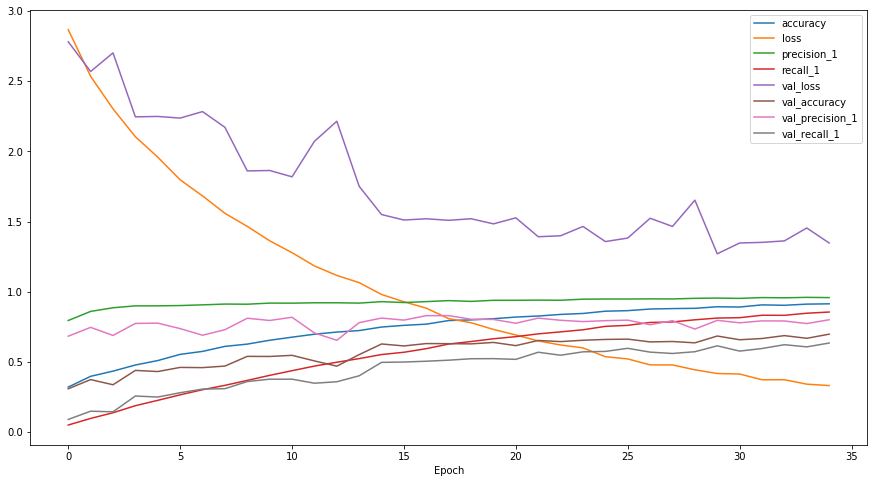

In [40]:
plt.figure(figsize=(15,8))
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['precision_1'], label='precision_1')
plt.plot(history.history['recall_1'], label='recall_1')
plt.plot(history.history['val_loss'], label='val_loss')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.plot(history.history['val_precision_1'], label='val_precision_1')
plt.plot(history.history['val_recall_1'], label='val_recall_1')
plt.xlabel('Epoch')
plt.legend()